In [ ]:
# from pathlib import Path
# from zipfile import ZipFile, BadZipFile

# base_dir = Path("data/tokyo_las").resolve()
# overwrite = False  # set to True to re-extract even if folder exists

# zip_paths = sorted(base_dir.glob("*.zip"))
# print(f"Found {len(zip_paths)} zip(s) in {base_dir}")

# extracted_count = 0
# skipped_count = 0
# failed = []

# for zp in zip_paths:
#     target_dir = base_dir / zp.stem
#     if target_dir.exists() and any(target_dir.iterdir()) and not overwrite:
#         skipped_count += 1
#         continue

#     try:
#         target_dir.mkdir(parents=True, exist_ok=True)
#         with ZipFile(zp) as zf:
#             zf.extractall(target_dir)
#         extracted_count += 1
#         # Uncomment to remove the zip after successful extraction
#         # zp.unlink()
#     except BadZipFile:
#         failed.append((zp.name, "BadZipFile"))
#     except Exception as e:
#         failed.append((zp.name, str(e)))

# print(f"Extracted: {extracted_count}, Skipped: {skipped_count}, Failed: {len(failed)}")
# if failed:
#     for name, err in failed:
#         print(f"- {name}: {err}")

In [ ]:
# Cell 1: Run nDSM pipeline for your LAS folder and rectangle
from tokyo_las import get_ndsm_geotiff_from_tokyo_dsm

# Define your rectangle in WGS84 (lon, lat). Example below — replace with your AOI.
rectangle_vertices = [
    (139.7600, 35.6800),  # lon, lat (SW)
    (139.7700, 35.6800),  # SE
    (139.7700, 35.6900),  # NE
    (139.7600, 35.6900),  # NW
]

las_dir = "data/tokyo_las"      # where your .las/.laz files are
output_dir = "data/temp"           # output directory
geotiff_name = "ndsm.tif"       # final cropped nDSM filename
resolution = 0.5                # raster resolution in meters for DSM/DTM
crop_pad_m = 2.0                # optional padding in meters around rectangle
use_polygon_mask = False        # True to mask by polygon instead of bbox window

ndsm_tiff_path = get_ndsm_geotiff_from_tokyo_dsm(
    rectangle_vertices=rectangle_vertices,
    las_dir=las_dir,
    output_dir=output_dir,
    geotiff_name=geotiff_name,
    resolution=resolution,
    crop_pad_m=crop_pad_m,
    use_polygon_mask=use_polygon_mask,
)
ndsm_tiff_path

Creating Land Use Land Cover grid
 
Data source: OpenEarthMapJapan
Composing image with dimensions: 1024x1024
GeoTIFF saved as 'data/temp\land_cover.tif' in Web Mercator projection (EPSG:3857).


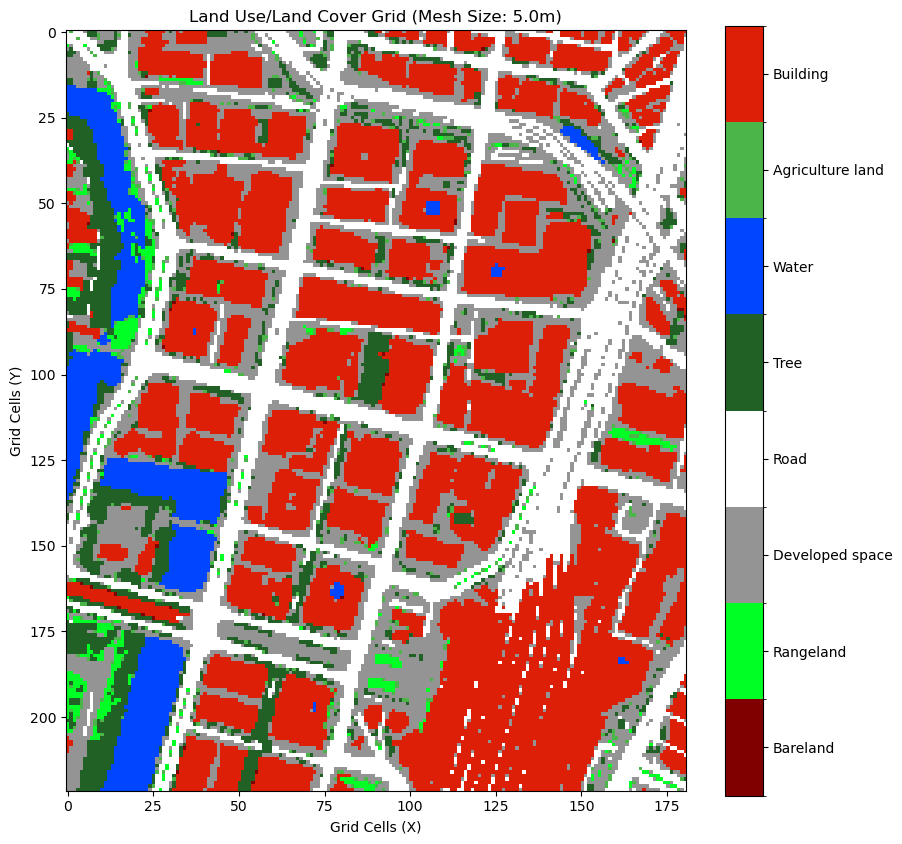


Step 3: Finding LAS files...
Found 144 LAS files
Filtering LAS files by AOI intersection...
Selected 15 / 144 LAS files intersecting AOI

Step 4: Processing LAS files to create DSM and DTM GeoTIFFs...
Processing file 1/15: 09LD1843.las
LAS file: data/tokyo_las\09LD1843\09LD1843.las
  Point count: 4798331
  X range: -6800.0 to -6400.001
  Y range: -34500.0 to -34200.001000000004
  Classifications: [1 2 3]
Saved raster to data/temp/dsm_geotiffs\09LD1843_dsm.tif
Saved raster to data/temp/dtm_geotiffs\09LD1843_dtm.tif
Processing file 2/15: 09LD1844.las
LAS file: data/tokyo_las\09LD1844\09LD1844.las
  Point count: 5658605
  X range: -6400.0 to -6000.001
  Y range: -34500.0 to -34200.001000000004
  Classifications: [1 2 3]
Saved raster to data/temp/dsm_geotiffs\09LD1844_dsm.tif
Saved raster to data/temp/dtm_geotiffs\09LD1844_dtm.tif
Processing file 3/15: 09LD1845.las
LAS file: data/tokyo_las\09LD1845\09LD1845.las
  Point count: 5844282
  X range: -6000.0 to -5600.001
  Y range: -34500.0 to 

2025-10-05 01:22:18,937 - ERROR - Could only read 6274074 of the requested 6895689 points


Saved raster to data/temp/dsm_geotiffs\09LD1863_dsm.tif
Saved raster to data/temp/dtm_geotiffs\09LD1863_dtm.tif
Processing file 8/15: 09LD1864.las
LAS file: data/tokyo_las\09LD1864\09LD1864.las
  Point count: 6274074
  X range: -6400.0 to -6000.001
  Y range: -35100.0 to -34800.001000000004
  Classifications: [1 2 3]
Saved raster to data/temp/dsm_geotiffs\09LD1864_dsm.tif
Saved raster to data/temp/dtm_geotiffs\09LD1864_dtm.tif
Processing file 9/15: 09LD1865.las
LAS file: data/tokyo_las\09LD1865\09LD1865.las
  Point count: 5868246
  X range: -6000.0 to -5600.001
  Y range: -35100.0 to -34800.001000000004
  Classifications: [1 2 3]
Saved raster to data/temp/dsm_geotiffs\09LD1865_dsm.tif
Saved raster to data/temp/dtm_geotiffs\09LD1865_dtm.tif
Processing file 10/15: 09LD1873.las
LAS file: data/tokyo_las\09LD1873\09LD1873.las
  Point count: 5299084
  X range: -6800.0 to -6400.001
  Y range: -35400.0 to -35100.001000000004
  Classifications: [1 2 3]
Saved raster to data/temp/dsm_geotiffs\09L

In [1]:
# Cell: Build canopy grid from OEMJ land cover + Tokyo nDSM (LAS at data/tokyo_las)
import numpy as np

from voxcity.generator import get_land_cover_grid
from voxcity.utils.visualization import get_land_cover_classes
from tokyo_las import (
    get_ndsm_grid,
    align_ndsm_to_landcover,
    build_canopy_from_ndsm,
    fill_canopy_gaps_with_nearest,
    remove_local_spikes_in_canopy,
    summarize_grid,
)

# Define your AOI and mesh size
rectangle_vertices = [
    (139.7600, 35.6800),  # lon, lat (SW)
    (139.7700, 35.6800),  # SE
    (139.7700, 35.6900),  # NE
    (139.7600, 35.6900),  # NW
]
meshsize = 5.0  # meters
output_dir = "data/temp"

# 1) Land cover (OpenEarthMapJapan)
land_cover_source = "OpenEarthMapJapan"
land_cover_grid = get_land_cover_grid(rectangle_vertices, meshsize, land_cover_source, output_dir)

# Resolve tree and building class IDs robustly for the chosen source
_lc_classes = get_land_cover_classes(land_cover_source)          # {(r,g,b): "ClassName", ...}
_name_to_id = {name: i for i, name in enumerate(_lc_classes.values())}

tree_id = (
    _name_to_id.get("Tree")
    or _name_to_id.get("Trees")
    or _name_to_id.get("Tree Canopy")
    or 4  # fallback commonly used for OEMJ
)

# Prefer explicit name match; avoid "or"-chain ambiguity for index 0
if "Building" in _name_to_id:
    building_id = _name_to_id["Building"]
elif "Buildings" in _name_to_id:
    building_id = _name_to_id["Buildings"]
elif "Building Footprint" in _name_to_id:
    building_id = _name_to_id["Building Footprint"]
else:
    building_id = 1  # reasonable fallback for OEMJ-like schemas

# 2) nDSM from Tokyo LAS (uses las_dir='data/tokyo_las' by default)
#    The grid returned by get_ndsm_grid is north-up; we align to land_cover_grid shape/orientation.
ndsm_grid = get_ndsm_grid(
    rectangle_vertices,
    meshsize,
    source="tokyo_dsm",
    output_dir=output_dir,
    las_dir="data/tokyo_las",  # make sure LAS/LAZ exist here
)
ndsm_aligned, align_info = align_ndsm_to_landcover(
    ndsm_grid,
    land_cover_grid,
    tree_value=tree_id,
    allow_resample=True,
    try_vertical_flip=True,  # will vertical-flip if it improves alignment over tree mask
)
print("Alignment info:", align_info)

# 3) Build initial canopy (nDSM heights only at tree cells; non-tree as NaN)
canopy_height_grid_initial = build_canopy_from_ndsm(
    ndsm_aligned,
    land_cover_grid,
    tree_value=tree_id,
    non_tree_fill=np.nan,
    clamp_negative_to_zero=True,
)

# 4) Fill gaps on tree cells from nearest valid nDSM neighbors (average ties)
canopy_height_grid = fill_canopy_gaps_with_nearest(
    canopy_height_grid_initial,
    ndsm_aligned,
    land_cover_grid,
    tree_value=tree_id,
    treat_zero_as_missing=False,
    restrict_neighbors_to_tree=True,
    allow_resample=False,
    max_neighbor_distance_m=5.0,
    cell_size_m=meshsize,
    fallback_tree_height_m=10.0,
)

# 5) Remove local spikes near buildings and isolated tall trees
canopy_height_grid_spike_free = remove_local_spikes_in_canopy(
    canopy_height_grid,
    land_cover_grid,
    tree_value=tree_id,
    building_value=building_id,
    high_threshold_m=10.0,
    building_buffer_m=15.0,
    cell_size_m=meshsize,
    replacement_tree_height_m=10.0,
)

# 6) Quick summary
summarize_grid("Canopy (filled)", canopy_height_grid)
summarize_grid("Canopy (spike-removed)", canopy_height_grid_spike_free)

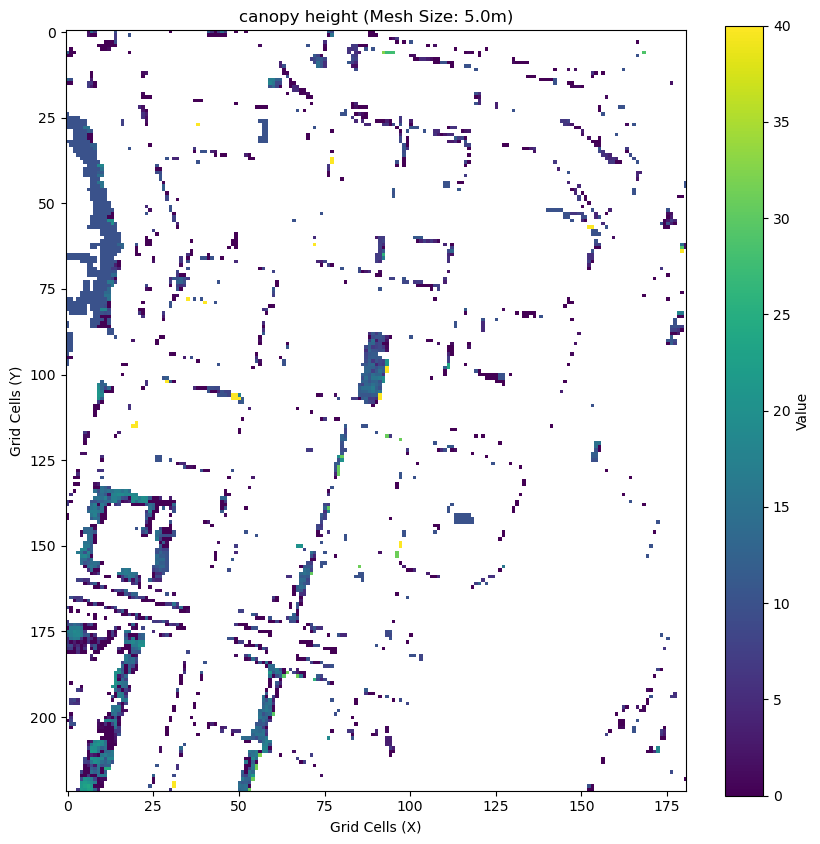

In [2]:
from voxcity.utils.visualization import visualize_numerical_grid_on_basemap, visualize_numerical_grid
import numpy as np

canopy_height_grid[canopy_height_grid == 0] = np.nan
# visualize_numerical_grid_on_basemap(canopy_height_grid, rectangle_vertices, meshsize, vmax=40)
visualize_numerical_grid(np.flipud(canopy_height_grid), meshsize, "canopy height", vmin=0, vmax=40)

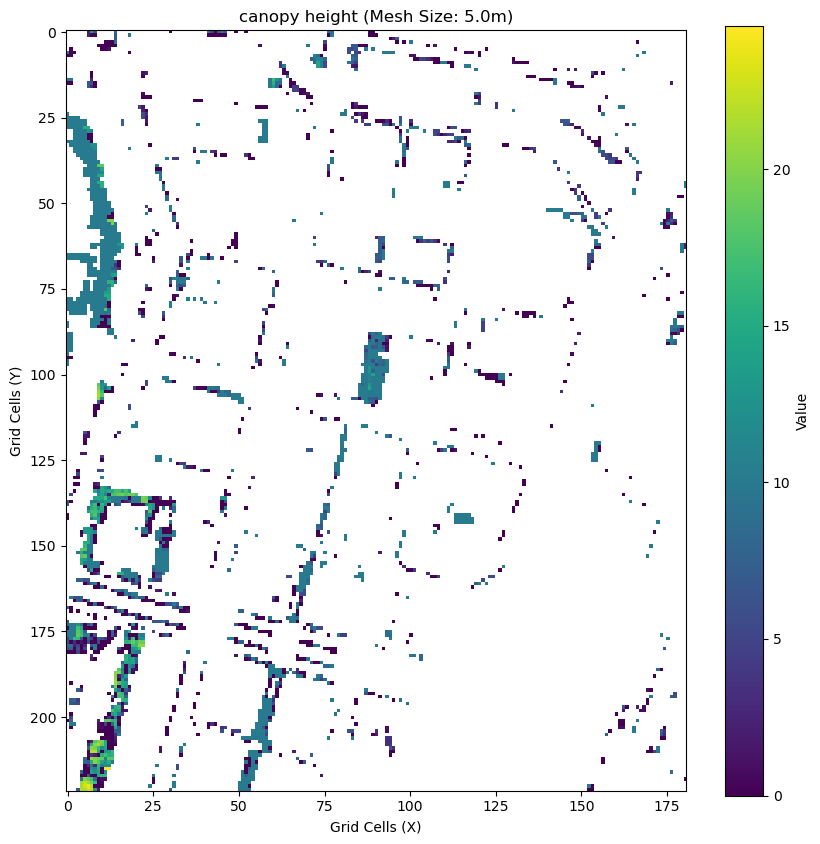

In [3]:
from voxcity.utils.visualization import visualize_numerical_grid_on_basemap, visualize_numerical_grid
import numpy as np

canopy_height_grid_spike_free[canopy_height_grid_spike_free == 0] = np.nan
# visualize_numerical_grid_on_basemap(canopy_height_grid, rectangle_vertices, meshsize, vmax=40)
visualize_numerical_grid(np.flipud(canopy_height_grid_spike_free), meshsize, "canopy height", vmin=0, vmax=None)